This notebook is my take on the Kaggle [competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview) on histopahalogic cancer detection. In this competition an algorithm must be created to identify metastatic cancer in small image patches taken from larger digital pathology scans. In this notebook we will first perform Exploratory Data Analysis (EDA), make a design for a convolutional neural network, train it and evaluate the performance. Finally we will use the generated model to predict outcomes on a test set provided by the competition.

Import required Python modules

In [129]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Read the training data labels

In [109]:
DATADIR = r'assignment/histopathologic-cancer-detection/train/'

In [116]:
df_train_data = pd.read_csv('assignment/histopathologic-cancer-detection/train_labels.csv',dtype=str)
# append file extension
df_train_data.id = df_train_data.id + '.tif'

Define function to display images from training folder

In [117]:
def read_img (filename) : 
    filepath = DATADIR + filename
    return plt.imread(filepath)
    
def show_img (image) :
    plt.figure()
    plt.imshow(image)
    
def read_show_img (filename) :
    I = read_img(filename)
    show_img(I)

131985    None
215628    None
31888     None
4465      None
189767    None
181303    None
54047     None
78471     None
31095     None
145061    None
Name: id, dtype: object

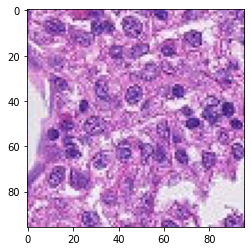

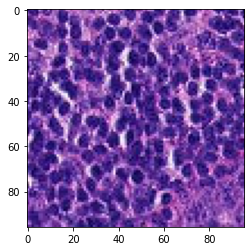

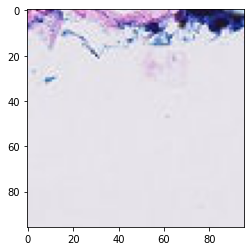

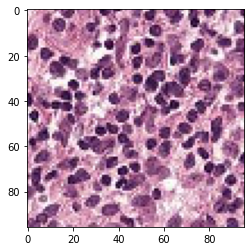

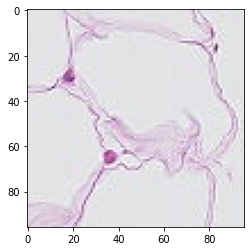

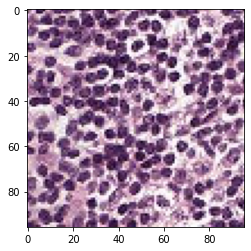

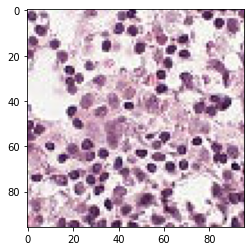

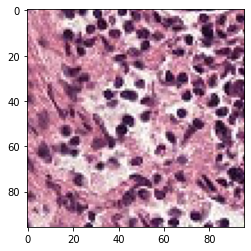

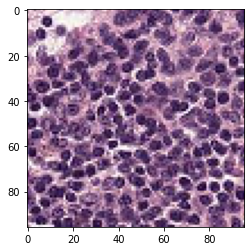

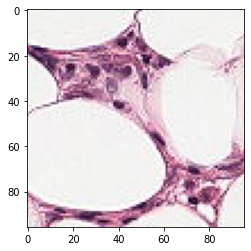

In [118]:
rand_1 = df_train_data[df_train_data.label=='1'].sample(10)
rand_0 = df_train_data[df_train_data.label=='0'].sample(10)

rand_0.id.apply(read_show_img)

81196     None
15911     None
115464    None
57674     None
115252    None
145643    None
187482    None
121879    None
143036    None
217048    None
Name: id, dtype: object

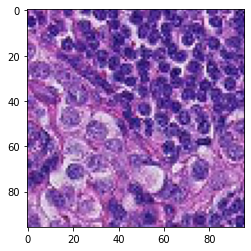

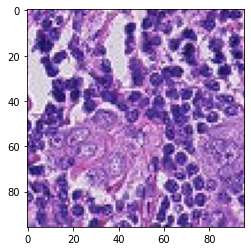

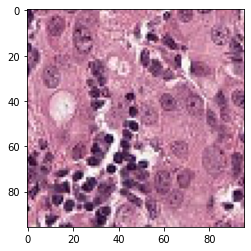

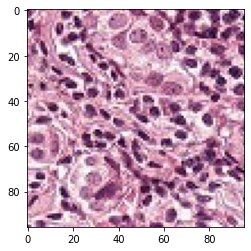

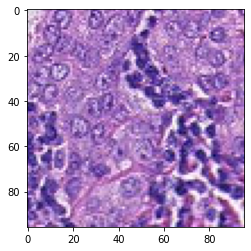

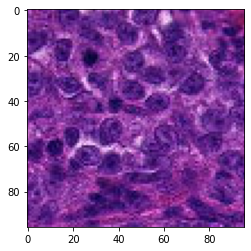

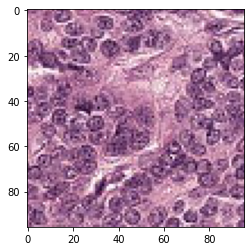

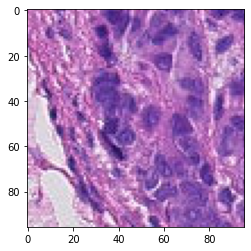

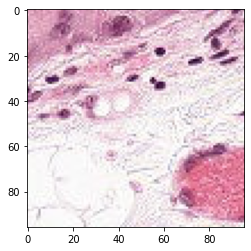

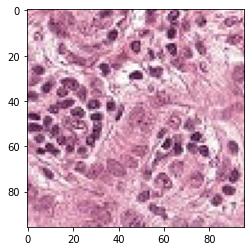

In [102]:
rand_1.id.apply(read_show_img)

Check if the training data is balanced, and check the size of individual images

<AxesSubplot:>

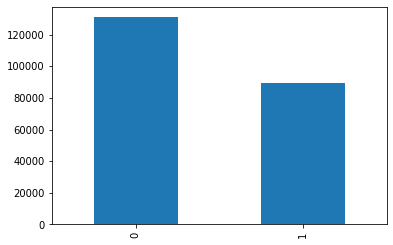

In [97]:
df_train_data.label.value_counts().plot.bar()

In [70]:
rand_img = df_train_data.sample(1)
I = rand_img.id.apply(read_img)
I.iloc[0].shape

(96, 96, 3)

So the size of the images is 96 by 96, with 3 values for colors R, G, B. In the description of the data I read the following: In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

In order to be able to train the model, we need to prepare the input data

In [80]:
batch_size = 32
img_height = 96
img_width = 96

In [104]:
split_size = 0.2
seed = 1337

In [119]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=split_size)

train_set = datagen.flow_from_dataframe(
    dataframe  = df_train_data,
    directory  = DATADIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'training',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = (96,96))

valid_set = datagen.flow_from_dataframe(
    dataframe  = df_train_data,
    directory  = DATADIR,
    color_mode = 'rgb',
    x_col      = 'id',
    y_col      = 'label',
    subset     = 'validation',
    batch_size = batch_size,
    seed       = seed,
    shuffle    = True,
    class_mode = 'binary',
    target_size = (96,96))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Define model parameters

In [127]:
train_steps = np.ceil(len(train_set) / batch_size)
val_steps = np.ceil(len(valid_set) / batch_size)

print('Steps:')
print('Train: %d | Validation: %d ' %(train_steps, val_steps))

Steps:
Train: 172 | Validation: 43 


Define model

In [121]:
kernel_size     = 3
pool_size       = 2

first_filters   = 32
second_filters  = 64
third_filters   = 128

dropout_conv = 0.3
dropout_dense = 0.3

optimizer       = Adam(learning_rate=0.0001)
loss            = 'binary_crossentropy'                      # 'categorical_crossentropy', 'binary_crossentropy'
metric          = 'accuracy'
epochs          = 10
val_split       = 0.2

In [122]:
def model_cnn(input_shape):
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = input_shape))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model    

In [123]:
model = model_cnn((96,96,3))
model.compile(loss=loss, optimizer=optimizer, metrics=[metric, tf.keras.metrics.AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 45, 45, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 45, 45, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 43, 43, 64)        18496     
                                                        

2022-06-24 21:48:04.805104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train the model

In [130]:
t = time.time()
h = model.fit(    x                = train_set,
                  steps_per_epoch  = train_steps,
                  validation_data  = valid_set,
                  validation_steps = val_steps,
                  epochs           = epochs)

print('Fitting model in %.2f secs' % (time.time()-t))

Epoch 1/10
172/172 [==============================] - 106s 611ms/step - loss: 0.6393 - accuracy: 0.6205 - auc: 0.6609 - val_loss: 0.5235 - val_accuracy: 0.7871 - val_auc: 0.8375
Epoch 2/10
172/172 [==============================] - 108s 630ms/step - loss: 0.4908 - accuracy: 0.7742 - auc: 0.8383 - val_loss: 0.4748 - val_accuracy: 0.7812 - val_auc: 0.8544
Epoch 3/10
172/172 [==============================] - 110s 640ms/step - loss: 0.4914 - accuracy: 0.7711 - auc: 0.8346 - val_loss: 0.4813 - val_accuracy: 0.7805 - val_auc: 0.8610
Epoch 4/10
172/172 [==============================] - 106s 616ms/step - loss: 0.5015 - accuracy: 0.7743 - auc: 0.8279 - val_loss: 0.4982 - val_accuracy: 0.7747 - val_auc: 0.8530
Epoch 5/10
172/172 [==============================] - 104s 602ms/step - loss: 0.4766 - accuracy: 0.7827 - auc: 0.8470 - val_loss: 0.4937 - val_accuracy: 0.7776 - val_auc: 0.8566
Epoch 6/10
172/172 [==============================] - 99s 573ms/step - loss: 0.4697 - accuracy: 0.7865 - auc: 

In [133]:
df_hist = pd.DataFrame(h.history)

<AxesSubplot:>

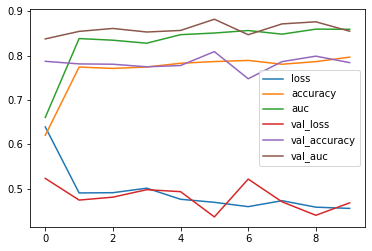

In [136]:
df_hist.plot.line()